In [1]:
import numpy as np
from numpy import arange
import pandas as pd
from pandas import read_table, set_option
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scipy.stats import chi2_contingency

## Load Data

In [2]:
#Loading the Data
db=pd.read_csv("COVID-19BehaviorData_CAN_USA.csv", error_bad_lines=False)

In [3]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28825 entries, 0 to 28824
Data columns (total 79 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Index               28825 non-null  int64  
 1   RecordNo            28825 non-null  object 
 2   endtime             28825 non-null  object 
 3   qweek               28825 non-null  object 
 4   i1_health           28825 non-null  int64  
 5   i2_health           28825 non-null  int64  
 6   i7a_health          28825 non-null  int64  
 7   i3_health           28825 non-null  object 
 8   i4_health           28825 non-null  object 
 9   i5_health_1         28825 non-null  object 
 10  i5_health_2         28825 non-null  object 
 11  i5_health_3         28825 non-null  object 
 12  i5_health_4         28825 non-null  object 
 13  i5_health_5         28825 non-null  object 
 14  i5_health_99        28825 non-null  object 
 15  i5a_health          28825 non-null  object 
 16  i6_h

## Data Cleaning

In [4]:
#Checking Missing Data and replace with NaN
db.replace(' ', np.nan, inplace=True)
db['i14_health_other'].replace('__NA__', np.nan, inplace = True)
db=pd.DataFrame(db)

#### Remove rows with more than 44 missing values

In [5]:
db['Raw_count']=db.apply(lambda x: x.count(),axis=1)
db_raw_delete=db[(db['Raw_count']<=43)].index
db.drop(db_raw_delete,inplace=True)

#### Remove 5 columns have more than 90% missing values

In [6]:
db.drop(['i5a_health', 'i6_health', 'i7b_health', 'i8_health', 'i14_health_other', 'Raw_count'], axis=1, inplace=True)

#### Number encode the categorical variables & Fill in missing values

In [7]:
db_missing=db.isna()
db.head()
db_num_missing=db_missing.sum()
df_missing=pd.DataFrame(db_num_missing)
column='# of missing value'
df_missing.columns=[column]
df_missing.loc[(df_missing!=0).any(1)]

#i3_health has 274 missing value
#i4_health has 671 missing value
#i5_health has 524 missing value
#i9_health has 1769 missing value
#i10_health has 1769 missing value
#i11_health has 1769 missing value
#i12_health_9 has 16298 missing value
#i12_health_10 has 18434 missing value

#i3_health has 274 missing value,using 99 to replace na means not sure
db['i3_health'].replace({"No, I have not":4,
                         "Yes, and I tested negative":2,
                         "Yes, and I tested positive":1,
                         "Yes, and I have not received my results from the test yet":3},inplace=True)
db['i3_health'].fillna(99,inplace=True)

#i4_health has 671 missing value,using 99 to replace na means not sure
db['i4_health'].replace({"No, they have not":4,
                         "Yes, and they tested negative":2,
                         "Yes, and they tested positive":1,
                         "Yes, and they have not received their results from the test yet":3,
                        "Not sure":99},inplace=True)
db['i4_health'].fillna(99,inplace=True)
#i5_health has 524 missing value,using 99 to replace na means not sure
i5_list=['i5_health_1','i5_health_2','i5_health_3','i5_health_4','i5_health_5','i5_health_99']
for i in i5_list:
    db[i].replace({"Yes":1,"No":0},inplace=True)
    db[i].fillna(99,inplace=True)

#i9_health has 1769 missing value,using 99 to replace na means not sure
db['i9_health'].unique()
db['i9_health'].replace({"Not sure":99,"Yes":1,"No":0},inplace=True)
db['i9_health'].fillna(99,inplace=True)

#i10_health has 1769 missing value,using 99 to replace na means not sure
db['i10_health'].replace({"Very easy":1,
                          "Somewhat easy":2,
                          "Neither easy nor difficult":3,
                         "Somewhat difficult":4,
                         "Very difficult":5,
                         "Not sure":99},inplace=True)
db['i10_health'].fillna(99,inplace=True)

#i11_health has 1769 missing value,using 99 to replace na means not sure
db['i11_health'].replace({"Very willing":1,
                          "Somewhat willing":2,
                          "Neither willing nor unwilling":3,
                         "Somewhat unwilling":4,
                         "Very unwilling":5,
                         "Not sure":99},inplace=True)
db['i11_health'].fillna(99,inplace=True)

#i12_health_9 has 16298 missing value,using 99 to replace na means not sure
db['i12_health_9'].replace({"Always":1,
                          "Frequently":2,
                          "Sometimes":3,
                         "Rarely":4,
                         "Not at all":5},inplace=True)
db['i12_health_9'].fillna(99,inplace=True)

#i12_health_10 has 18434 missing value,using 99 to replace na means not sure
db['i12_health_10'].replace({"Always":1,
                          "Frequently":2,
                          "Sometimes":3,
                         "Rarely":4,
                         "Not at all":5},inplace=True)
db['i12_health_10'].fillna(99,inplace=True)

In [8]:
alist=['i12_health_1','i12_health_2','i12_health_3','i12_health_4','i12_health_5','i12_health_6',
       'i12_health_7','i12_health_8','i12_health_11','i12_health_12','i12_health_13','i12_health_14',
       'i12_health_15','i12_health_16','i12_health_17','i12_health_18','i12_health_19','i12_health_20']

for i in alist:
    db[i].replace({"Always":1,"Frequently":2,"Sometimes":3,"Rarely":4,"Not at all":5},inplace=True)
    db[i].fillna(99,inplace=True)

In [9]:
#All i14 columns with missing value either retired, not working or student, so the default with missing value is No.
db.loc[:, 'i14_health_1':'i14_health_99'].replace(np.nan, "No", inplace = True)

In [10]:
# cleaning demographics related cols
db.loc[:,'household_size'].replace({
    "1":1,"2":2,"3":3,"4":4,"5":5,"6":6,"7":7,"8 or more":8,"Don't know":9,"Prefer not to say":10
},inplace=True)

db.loc[:,'household_children'].replace({
    "0":0, "1":1,"2":2,"3":3,"4":4,"5":5,"5 or more":6,"Don't know":7,"Prefer not to say":8
},inplace=True)

db.loc[:,'gender'].replace({"Male":1,"Female":2},inplace=True)

db.loc[:,'employment_status'].replace({"Full time employment":1,
                                       "Part time employment":2,
                                       "Full time student":3,
                                       "Retired":4,
                                       "Unemployed":5,
                                       "Not working":6,
                                       "Other":7},inplace=True)

#### Number encoding variables in i14 group and disease group

In [11]:
occupation_dummies = pd.get_dummies(db.loc[:, 'i14_health_1':'i14_health_99'])
db = pd.concat([db, occupation_dummies], axis=1)

disease_dummies = pd.get_dummies(db.loc[:, 'd1_health_1':'d1_health_99'])
db = pd.concat([db, disease_dummies], axis=1)

In [12]:
db=db.drop(db.loc[:, 'd1_health_1':'d1_health_99'],axis=1)
db=db.drop(db.loc[:, 'i14_health_1':'i14_health_99'],axis=1)

i14_NO = ['i14_health_1_No', 'i14_health_2_No', 'i14_health_3_No', 'i14_health_4_No', 'i14_health_5_No',
          'i14_health_6_No','i14_health_7_No', 'i14_health_8_No', 'i14_health_9_No', 'i14_health_10_No',
          'i14_health_96_No', 'i14_health_98_No', 'i14_health_99_No']

d1_NO = ['d1_health_1_No', 'd1_health_2_No', 'd1_health_3_No', 'd1_health_4_No', 'd1_health_5_No', 
         'd1_health_6_No','d1_health_7_No', 'd1_health_8_No', 'd1_health_9_No', 'd1_health_10_No', 
         'd1_health_11_No', 'd1_health_12_No', 'd1_health_13_No', 'd1_health_98_No', 'd1_health_99_No']

db=db.drop(i14_NO,axis=1)
db=db.drop(d1_NO,axis=1)

#### Remove insensible data points

In [13]:
db=db[db['i1_health']<=6]
db=db[db['i2_health']<=15] 

In [14]:
i14 = ['i14_health_1_Yes', 'i14_health_2_Yes', 'i14_health_3_Yes', 'i14_health_4_Yes', 'i14_health_5_Yes',
       'i14_health_6_Yes', 'i14_health_7_Yes', 'i14_health_8_Yes', 'i14_health_9_Yes', 'i14_health_10_Yes', 
       'i14_health_96_Yes', 'i14_health_98_Yes', 'i14_health_99_Yes']
db['Number_Occupation'] = db.loc[:, i14].sum(1)

d = ['d1_health_1_Yes', 'd1_health_2_Yes', 'd1_health_3_Yes', 'd1_health_4_Yes', 'd1_health_5_Yes', 'd1_health_6_Yes',
     'd1_health_7_Yes', 'd1_health_8_Yes', 'd1_health_9_Yes', 'd1_health_10_Yes', 'd1_health_11_Yes', 'd1_health_12_Yes', 
     'd1_health_13_Yes', 'd1_health_98_Yes', 'd1_health_99_Yes']
db['Number_Disease'] = db.loc[:, d].sum(1)

db=db[db['Number_Occupation']<4]
db=db[db['Number_Disease']<7]

db = db.drop(['Number_Occupation', 'Number_Disease'], axis = 1)

In [15]:
db.rename(columns={'i12_health_6':'Target_Variable'},inplace=True)
db['Target_Variable'].replace({1:1, 2:2, 3:3, 4:4, 5:4}, inplace = True)

#### Feature engineering - derive new variables from existing variables

In [16]:
db['Country']= db["RecordNo"].apply(lambda x: x[:3])

db['Country'].replace({
    "CAN":1,
    "USA":2},inplace=True)

In [17]:
db[["Name","Week"]]=db.qweek.str.split(expand=True)
db=db.drop({'qweek','Name', "RecordNo","endtime"},axis=1)


#### Remove the region_state variable 

In [18]:
db=db.drop('region_state',axis=1)

## EDA

### Distribution of the target variable

Text(0.5, 0, 'Avoided going out in general')

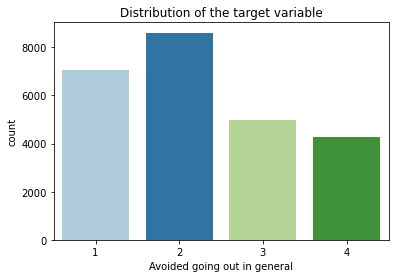

In [19]:
sns.set_palette('Paired')
fig = plt.figure()
ax = sns.countplot(x = 'Target_Variable', data = db)
ax.set_title('Distribution of the target variable')
ax.set_xlabel('Avoided going out in general')

### Heatmaps

In [20]:
cols = db.columns.tolist()

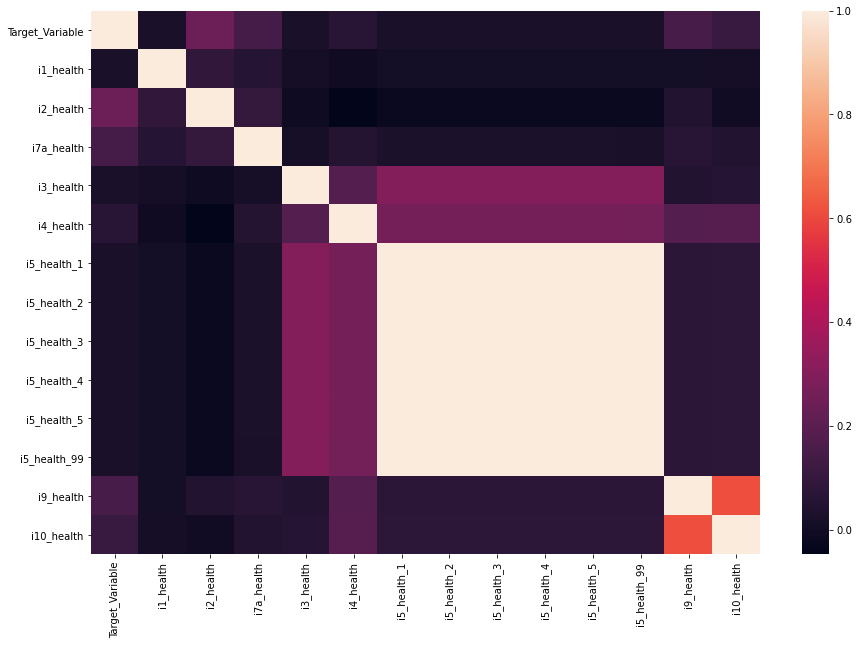

In [21]:
a1 = cols.index('i1_health')
a2 = cols.index('i10_health') + 1

col_new=[]
col_new.append(cols[20])
col_new=col_new+cols[a1:a2]

f, ax = plt.subplots(figsize=(15,10))
cor_matrix1 = db.loc[:,col_new].corr()
sns.heatmap(data = cor_matrix1)

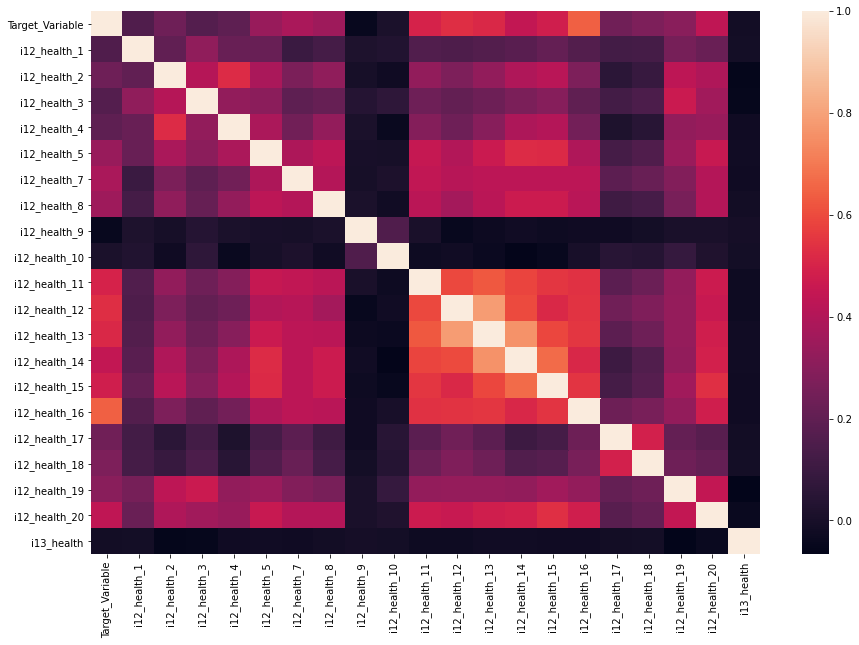

In [22]:
a1 = cols.index('i12_health_1')
a2 = cols.index('i12_health_5') + 1
b1 = cols.index('i12_health_7')
b2 = cols.index('i13_health') + 1 

col_new=[]
col_new.append(cols[20])
col_new=col_new+cols[a1:a2]+cols[b1: b2]

f, ax = plt.subplots(figsize=(15,10))

cor_matrix2 = db.loc[:,col_new].corr()
sns.heatmap(data = cor_matrix2)

In [23]:
# i12 
i12=['i12_health_1','i12_health_2','i12_health_3','i12_health_4','i12_health_5',
       'i12_health_7','i12_health_8','i12_health_9','i12_health_10','i12_health_11','i12_health_12','i12_health_13','i12_health_14',
       'i12_health_15','i12_health_16','i12_health_17','i12_health_18','i12_health_19','i12_health_20']

variable = []
teststat = []
pval = []

description = ['Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road)', 
               'Washed hands with soap and water', 
               'Used hand sanitiser', 
               'Covered your nose and mouth when sneezing or coughing', 
               'Avoided contact with people who have symptoms or you think may have been exposed to the coronavirus',
               'Avoided going to hospital or other healthcare settings',
              'Avoided taking public transport',
              'Avoided working outside your home',
              'Avoided letting your children go to school/ university',
              'Avoided having guests to your home',
              'Avoided small social gatherings (not more than 2 people)',
              'Avoided medium-sized social gatherings (between 3 and 10 people)',
              'Avoided large-sized social gatherings (more than 10 people)',
              'Avoided crowded areas',
              'Avoided going to shops',
              'Slept in separate bedrooms at home, when normally you would share a bedroom',
              'Eaten separately at home, when normally you would eat a meal with others',
              'Cleaned frequently touched surfaces in the home (e.g. doorknobs, toilets, taps)',
              'Avoided touching objects in public (e.g. elevator buttons or doors)']

for i in i12:
    i12_crosstab = pd.crosstab(db[i], db['Target_Variable'], margins = False)
    stat, p, dof, expected = chi2_contingency(i12_crosstab)
    variable.append(i)
    teststat.append(stat) 
    pval.append(p)

chi_data = pd.DataFrame(list(zip(variable, teststat, pval, description)), columns =['Variable', 'Test statistics', 'pvalue', 'Description']) 
chi_data.sort_values('pvalue', inplace=True)
chi_data

,Variable,Test statistics,pvalue,Description
0,i12_health_1,1561.624517,0.0,Worn a face mask outside your home (e.g. when ...
16,i12_health_18,2930.621082,0.0,"Eaten separately at home, when normally you wo..."
15,i12_health_17,2109.705082,0.0,"Slept in separate bedrooms at home, when norma..."
14,i12_health_16,17547.444688,0.0,Avoided going to shops
13,i12_health_15,8403.106193,0.0,Avoided crowded areas
12,i12_health_14,6993.084728,0.0,Avoided large-sized social gatherings (more th...
11,i12_health_13,9374.360262,0.0,Avoided medium-sized social gatherings (betwee...
10,i12_health_12,9778.970837,0.0,Avoided small social gatherings (not more than...
17,i12_health_19,3690.246110,0.0,Cleaned frequently touched surfaces in the hom...
9,i12_health_11,8849.035618,0.0,Avoided having guests to your home


In [24]:
db['Precaution'] = db.loc[:, i12].sum(1)
db['Precaution_Yes']= db["Precaution"].apply(lambda x: 1 if x > 0 else 0)
db=db.drop('Precaution',axis=1)
Precaution_crosstab = pd.crosstab(db['Precaution_Yes'], db['Target_Variable'], margins = False)
stat, p, dof, expected = chi2_contingency(Precaution_crosstab)
print("Test statistics: ",stat,"\np-value: ",p)

Test statistics:  0.0 
p-value:  1.0


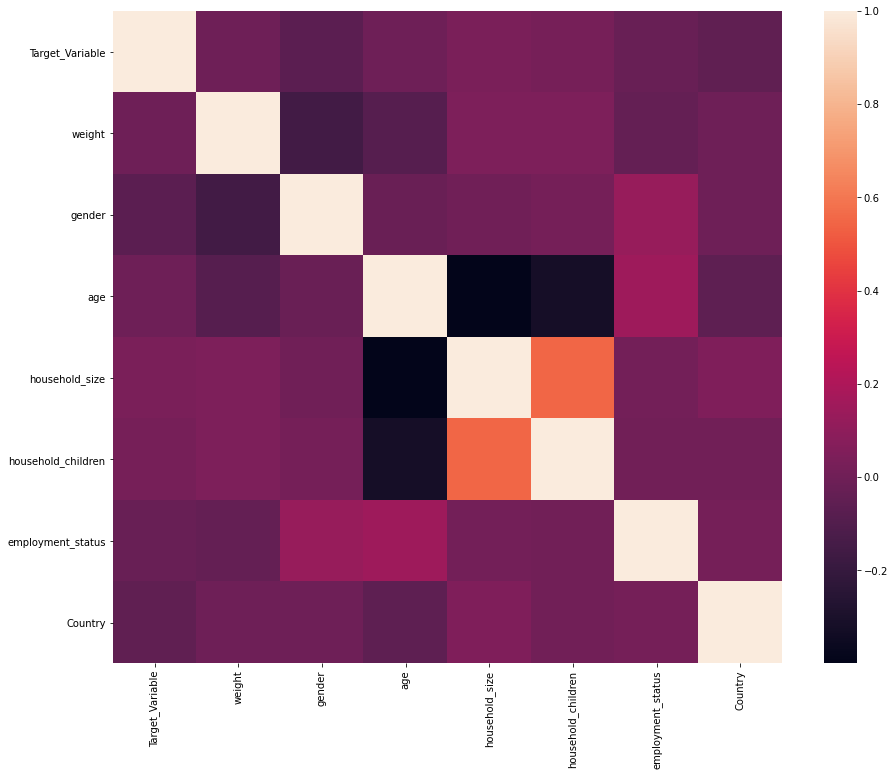

In [25]:
a1 = cols.index('weight')
a2 = cols.index('employment_status') + 1
a3 = cols.index('Country')

col_new=[]
col_new.append(cols[20])
col_new=col_new+cols[a1:a2] + cols[a3:a3+1]

f, ax = plt.subplots(figsize=(15,12))

cor_matrix3 = db.loc[:,col_new].corr()
sns.heatmap(data = cor_matrix3)

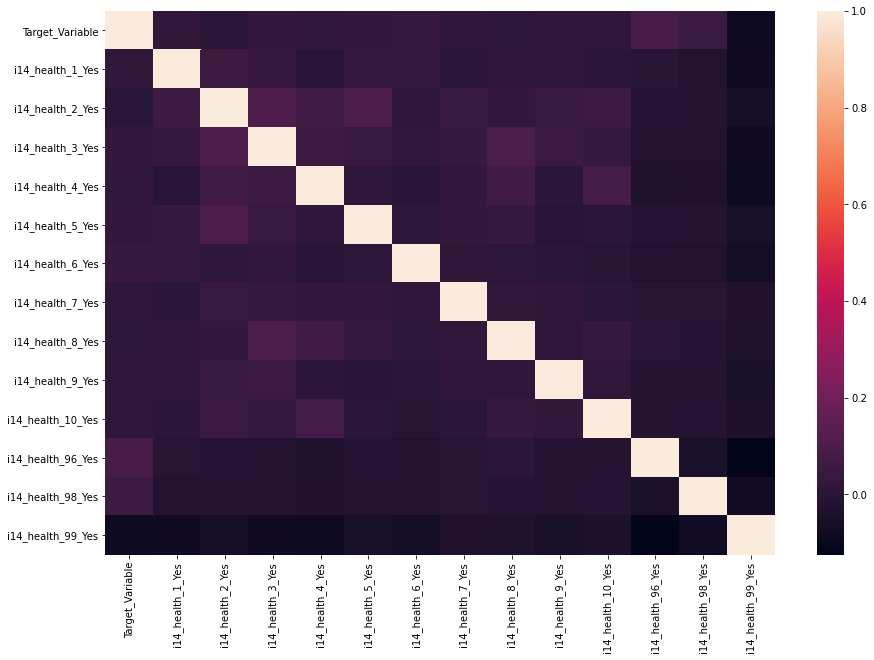

In [26]:
a1 = cols.index('i14_health_1_Yes')
a2 = cols.index('i14_health_99_Yes') + 1

col_new=[]
col_new.append(cols[20])
col_new=col_new+cols[a1:a2]

f, ax = plt.subplots(figsize=(15,10))

cor_matrix4 = db.loc[:,col_new].corr()
sns.heatmap(data = cor_matrix4)

In [27]:
# i14
variable = []
teststat = []
pval = []

description = ['Construction','Delivering to homes','Food retail','Healthcare','Logistics / other transportation','Manufacturing',
              'Policing or prisons', 'Public transport', 'School','Social care','Other','Not sure','No, will not be working outside my home']

for i in i14:
    i14_crosstab = pd.crosstab(db[i], db['Target_Variable'], margins = False)
    stat, p, dof, expected = chi2_contingency(i14_crosstab)
    variable.append(i)
    teststat.append(stat) 
    pval.append(p)

chi_data = pd.DataFrame(list(zip(variable, teststat, pval, description)), columns =['Variable', 'Test statistics', 'pvalue' ,'Discription']) 
chi_data.sort_values('pvalue', inplace=True)
chi_data

,Variable,Test statistics,pvalue,Discription
10,i14_health_96_Yes,206.151371,1.976621e-44,Other
12,i14_health_99_Yes,198.225054,1.020165e-42,"No, will not be working outside my home"
11,i14_health_98_Yes,71.192436,2.370787e-15,Not sure
5,i14_health_6_Yes,40.572495,8.057204e-09,Manufacturing
2,i14_health_3_Yes,34.598318,1.481108e-07,Food retail
0,i14_health_1_Yes,21.952906,6.671959e-05,Construction
4,i14_health_5_Yes,20.934770,1.086115e-04,Logistics / other transportation
3,i14_health_4_Yes,20.135359,1.591235e-04,Healthcare
8,i14_health_9_Yes,18.893799,2.875760e-04,School
9,i14_health_10_Yes,10.035416,1.826748e-02,Social care


In [28]:
db['Occ'] = db.loc[:, ['i14_health_96_Yes','i14_health_98_Yes', 'i14_health_6_Yes', 'i14_health_3_Yes', 'i14_health_1_Yes', 'i14_health_5_Yes', 'i14_health_4_Yes']].sum(1)
db['Occ_Yes']= db["Occ"].apply(lambda x: 1 if x > 0 else 0)
db=db.drop('Occ',axis=1)
Occupation_crosstab = pd.crosstab(db['Occ_Yes'], db['Target_Variable'], margins = False)
stat, p, dof, expected = chi2_contingency(Occupation_crosstab)
print("Test statistics: ",stat,"\np-value: ",p)

Test statistics:  396.00733594409473 
p-value:  1.6217497478570637e-85


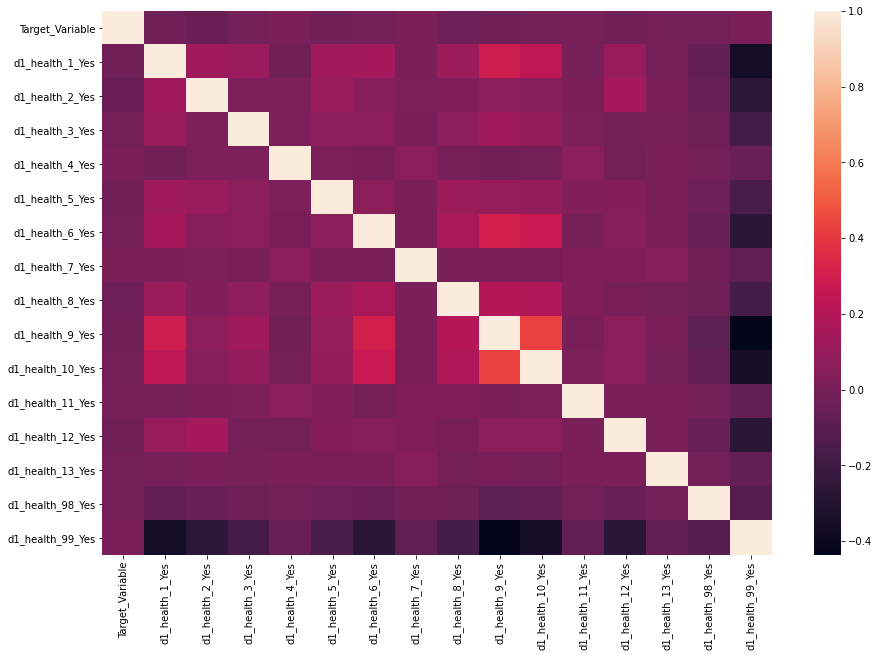

In [29]:
a1 = cols.index('d1_health_1_Yes')
a2 = cols.index('d1_health_99_Yes') + 1

col_new=[]
col_new.append(cols[20])
col_new=col_new+cols[a1:a2]

f, ax = plt.subplots(figsize=(15,10))

cor_matrix5 = db.loc[:,col_new].corr()
sns.heatmap(data = cor_matrix5)

In [30]:
# d1
variable = []
teststat = []
pval = []

description = ['Arthritis', 'Asthma', 'Cancer', 'Cystic fibrosis', 'Chronic obstructive pulmonary disease (COPD)', 
              'Diabetes', 'Epilepsy', 'Heart disease', 'High blood pressure', 'High cholesterol', 
              'HIV/ Aids', 'Mental health condition', 'Multiple Sclerosis', 'Prefer not to say', 'None of these']
for i in d:
    d1_crosstab = pd.crosstab(db[i], db['Target_Variable'], margins = False)
    stat, p, dof, expected = chi2_contingency(d1_crosstab)
    variable.append(i)
    teststat.append(stat) 
    pval.append(p)

chi_data = pd.DataFrame(list(zip(variable, teststat, pval, description)), columns =['Variable', 'Test statistics', 'pvalue', 'Description']) 
chi_data.sort_values('pvalue', inplace=True)
chi_data

,Variable,Test statistics,pvalue,Description
1,d1_health_2_Yes,53.949215,1.150394e-11,Asthma
11,d1_health_12_Yes,53.846003,1.210202e-11,Mental health condition
7,d1_health_8_Yes,23.524356,3.139472e-05,Heart disease
14,d1_health_99_Yes,19.921259,1.762411e-04,None of these
0,d1_health_1_Yes,18.642085,3.241670e-04,Arthritis
13,d1_health_98_Yes,11.963910,7.507816e-03,Prefer not to say
4,d1_health_5_Yes,11.037951,1.152242e-02,Chronic obstructive pulmonary disease (COPD)
8,d1_health_9_Yes,10.147011,1.735695e-02,High blood pressure
6,d1_health_7_Yes,7.877705,4.860796e-02,Epilepsy
9,d1_health_10_Yes,5.990404,1.120780e-01,High cholesterol


In [31]:
db['Disease'] = db.loc[:, ['d1_health_2_Yes','d1_health_12_Yes','d1_health_8_Yes', 'd1_health_99_Yes', 'd1_health_1_Yes', 'd1_health_98_Yes']].sum(1)
db['Disease_Yes']= db["Disease"].apply(lambda x: 1 if x > 0 else 0)
db=db.drop('Disease',axis=1)
disease_crosstab = pd.crosstab(db['Disease_Yes'], db['Target_Variable'], margins = False)
stat, p, dof, expected = chi2_contingency(disease_crosstab)
print("Test statistics: ",stat,"\np-value: ",p)

Test statistics:  31.36944736829081 
p-value:  7.106252126489939e-07


### Distributions of the highly correlated variables

<Figure size 432x288 with 0 Axes>

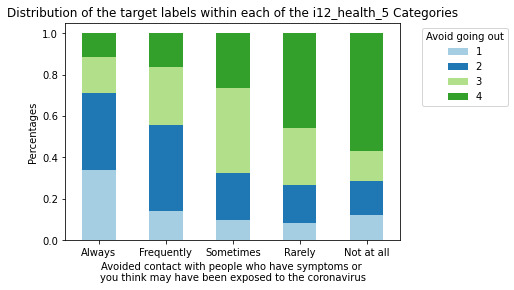

In [32]:
sns.set_palette('Paired')
fig = plt.figure()
i12_5_crosstab = pd.crosstab(db['i12_health_5'], db['Target_Variable'], margins = False)
i12_5_crosstab_norm = i12_5_crosstab.div(i12_5_crosstab.sum(axis = 1), axis = 0)
ax = i12_5_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the i12_health_5 Categories', 
      xlabel = 'Avoided contact with people who have symptoms or \nyou think may have been exposed to the coronavirus',
      ylabel = 'Percentages',
      xticklabels=['Always','Frequently','Sometimes','Rarely','Not at all'])
plt.xticks(rotation = None)
plt.legend(title='Avoid going out', bbox_to_anchor=(1.05, 1), loc='upper left')

<Figure size 432x288 with 0 Axes>

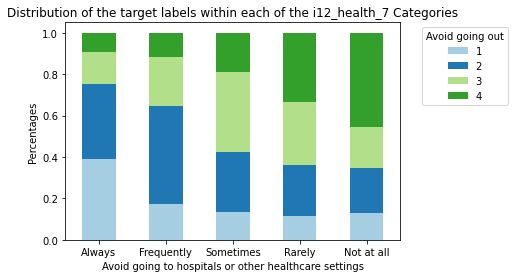

In [33]:
sns.set_palette('Paired')
fig = plt.figure()
i12_7_crosstab = pd.crosstab(db['i12_health_7'], db['Target_Variable'], margins = False)
i12_7_crosstab_norm = i12_7_crosstab.div(i12_7_crosstab.sum(axis = 1), axis = 0)
ax = i12_7_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the i12_health_7 Categories', 
      xlabel = 'Avoid going to hospitals or other healthcare settings',
      ylabel = 'Percentages',
      xticklabels=['Always','Frequently','Sometimes','Rarely','Not at all'])
plt.xticks(rotation = None)
plt.legend(title='Avoid going out', bbox_to_anchor=(1.05, 1), loc='upper left')

<Figure size 432x288 with 0 Axes>

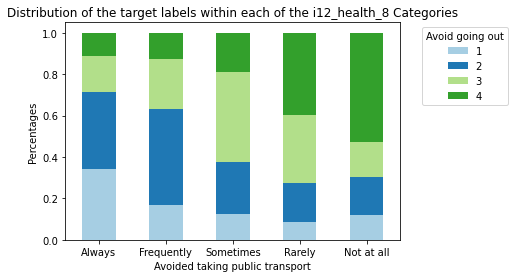

In [34]:
fig = plt.figure()
i12_8_crosstab = pd.crosstab(db['i12_health_8'], db['Target_Variable'], margins = False)
i12_8_crosstab_norm = i12_8_crosstab.div(i12_8_crosstab.sum(axis = 1), axis = 0)
ax = i12_8_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the i12_health_8 Categories', 
      xlabel = 'Avoided taking public transport',
      ylabel = 'Percentages',
      xticklabels=['Always','Frequently','Sometimes','Rarely','Not at all'])
plt.xticks(rotation = None)
plt.legend(title='Avoid going out', bbox_to_anchor=(1.05, 1), loc='upper left')

<Figure size 432x288 with 0 Axes>

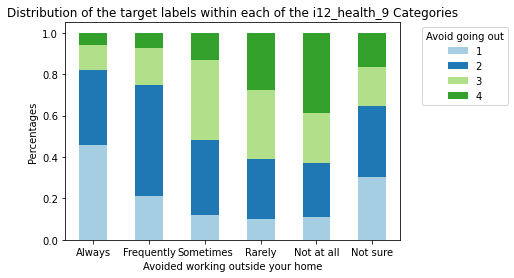

In [35]:
fig = plt.figure()
i12_9_crosstab = pd.crosstab(db['i12_health_9'], db['Target_Variable'], margins = False)
i12_9_crosstab_norm = i12_9_crosstab.div(i12_9_crosstab.sum(axis = 1), axis = 0)
ax = i12_9_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the i12_health_9 Categories', 
      xlabel = 'Avoided working outside your home',
      ylabel = 'Percentages',
      xticklabels=['Always','Frequently','Sometimes','Rarely','Not at all', 'Not sure'])
plt.xticks(rotation = None)
plt.legend(title='Avoid going out', bbox_to_anchor=(1.05, 1), loc='upper left')

<Figure size 432x288 with 0 Axes>

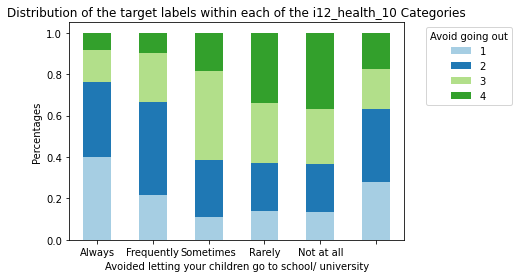

In [36]:
fig = plt.figure()
i12_10_crosstab = pd.crosstab(db['i12_health_10'], db['Target_Variable'], margins = False)
i12_10_crosstab_norm = i12_10_crosstab.div(i12_10_crosstab.sum(axis = 1), axis = 0)
ax = i12_10_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the i12_health_10 Categories', 
      xlabel = 'Avoided letting your children go to school/ university',
      ylabel = 'Percentages',
      xticklabels=['Always','Frequently','Sometimes','Rarely','Not at all'])
plt.xticks(rotation = None)
plt.legend(title='Avoid going out', bbox_to_anchor=(1.05, 1), loc='upper left')

<Figure size 432x288 with 0 Axes>

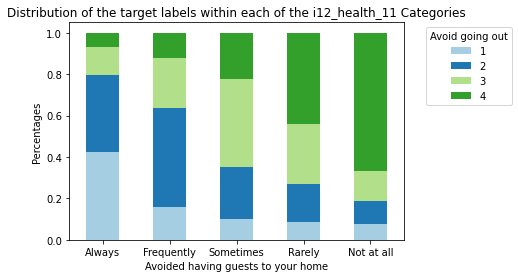

In [37]:
fig = plt.figure()
i12_11_crosstab = pd.crosstab(db['i12_health_11'], db['Target_Variable'], margins = False)
i12_11_crosstab_norm = i12_11_crosstab.div(i12_11_crosstab.sum(axis = 1), axis = 0)
ax = i12_11_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the i12_health_11 Categories', 
      xlabel = 'Avoided having guests to your home',
      ylabel = 'Percentages',
      xticklabels=['Always','Frequently','Sometimes','Rarely','Not at all'])
plt.xticks(rotation = None)
plt.legend(title='Avoid going out', bbox_to_anchor=(1.05, 1), loc='upper left')

<Figure size 432x288 with 0 Axes>

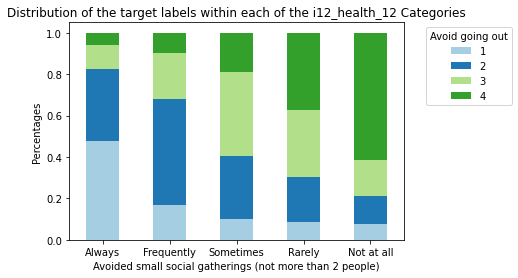

In [38]:
fig = plt.figure()
i12_12_crosstab = pd.crosstab(db['i12_health_12'], db['Target_Variable'], margins = False)
i12_12_crosstab_norm = i12_12_crosstab.div(i12_12_crosstab.sum(axis = 1), axis = 0)
ax = i12_12_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the i12_health_12 Categories', 
      xlabel = 'Avoided small social gatherings (not more than 2 people)',
      ylabel = 'Percentages',
      xticklabels=['Always','Frequently','Sometimes','Rarely','Not at all'])
plt.xticks(rotation = None)
plt.legend(title='Avoid going out', bbox_to_anchor=(1.05, 1), loc='upper left')

<Figure size 432x288 with 0 Axes>

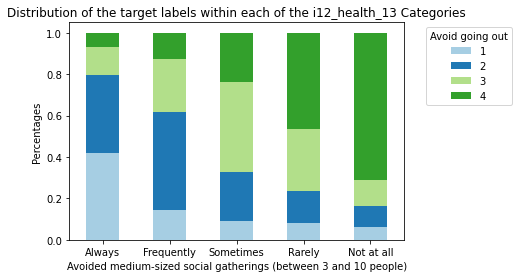

In [39]:
fig = plt.figure()
i12_13_crosstab = pd.crosstab(db['i12_health_13'], db['Target_Variable'], margins = False)
i12_13_crosstab_norm = i12_13_crosstab.div(i12_13_crosstab.sum(axis = 1), axis = 0)
ax = i12_13_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the i12_health_13 Categories', 
      xlabel = 'Avoided medium-sized social gatherings (between 3 and 10 people)',
      ylabel = 'Percentages',
      xticklabels=['Always','Frequently','Sometimes','Rarely','Not at all'])
plt.xticks(rotation = None)
plt.legend(title='Avoid going out', bbox_to_anchor=(1.05, 1), loc='upper left')

<Figure size 432x288 with 0 Axes>

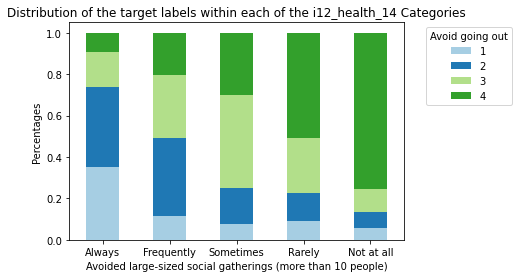

In [40]:
fig = plt.figure()
i12_14_crosstab = pd.crosstab(db['i12_health_14'], db['Target_Variable'], margins = False)
i12_14_crosstab_norm = i12_14_crosstab.div(i12_14_crosstab.sum(axis = 1), axis = 0)
ax = i12_14_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the i12_health_14 Categories', 
      xlabel = 'Avoided large-sized social gatherings (more than 10 people)',
      ylabel = 'Percentages',
      xticklabels=['Always','Frequently','Sometimes','Rarely','Not at all'])
plt.xticks(rotation = None)
plt.legend(title='Avoid going out', bbox_to_anchor=(1.05, 1), loc='upper left')

<Figure size 432x288 with 0 Axes>

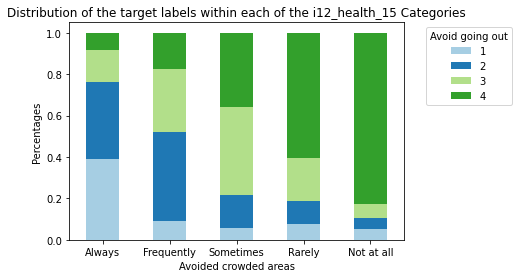

In [41]:
fig = plt.figure()
i12_15_crosstab = pd.crosstab(db['i12_health_15'], db['Target_Variable'], margins = False)
i12_15_crosstab_norm = i12_15_crosstab.div(i12_15_crosstab.sum(axis = 1), axis = 0)
ax = i12_15_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the i12_health_15 Categories', 
      xlabel = 'Avoided crowded areas',
      ylabel = 'Percentages',
      xticklabels=['Always','Frequently','Sometimes','Rarely','Not at all'])
plt.xticks(rotation = None)
plt.legend(title='Avoid going out', bbox_to_anchor=(1.05, 1), loc='upper left')

<Figure size 432x288 with 0 Axes>

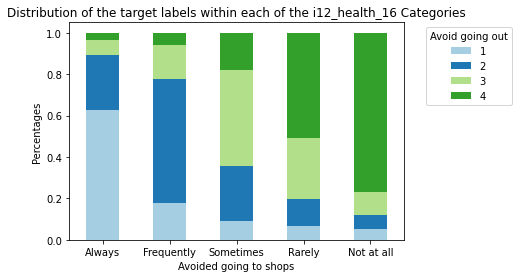

In [42]:
fig = plt.figure()
i12_16_crosstab = pd.crosstab(db['i12_health_16'], db['Target_Variable'], margins = False)
i12_16_crosstab_norm = i12_16_crosstab.div(i12_16_crosstab.sum(axis = 1), axis = 0)
ax = i12_16_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the i12_health_16 Categories', 
      xlabel = 'Avoided going to shops',
      ylabel = 'Percentages',
      xticklabels=['Always','Frequently','Sometimes','Rarely','Not at all'])
plt.xticks(rotation = None)
plt.legend(title='Avoid going out', bbox_to_anchor=(1.05, 1), loc='upper left')

<Figure size 432x288 with 0 Axes>

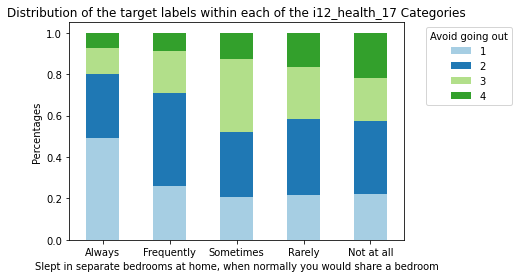

In [43]:
fig = plt.figure()
i12_17_crosstab = pd.crosstab(db['i12_health_17'], db['Target_Variable'], margins = False)
i12_17_crosstab_norm = i12_17_crosstab.div(i12_17_crosstab.sum(axis = 1), axis = 0)
ax = i12_17_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the i12_health_17 Categories', 
      xlabel = 'Slept in separate bedrooms at home, when normally you would share a bedroom',
      ylabel = 'Percentages',
      xticklabels=['Always','Frequently','Sometimes','Rarely','Not at all'])
plt.xticks(rotation = None)
plt.legend(title='Avoid going out', bbox_to_anchor=(1.05, 1), loc='upper left')

<Figure size 432x288 with 0 Axes>

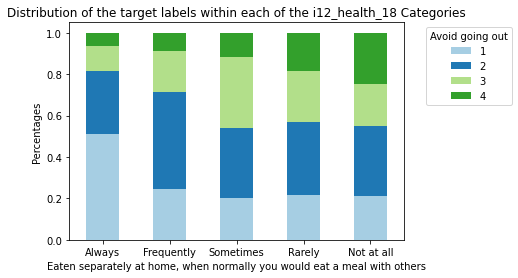

In [44]:
fig = plt.figure()
i12_18_crosstab = pd.crosstab(db['i12_health_18'], db['Target_Variable'], margins = False)
i12_18_crosstab_norm = i12_18_crosstab.div(i12_18_crosstab.sum(axis = 1), axis = 0)
ax = i12_18_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the i12_health_18 Categories', 
      xlabel = 'Eaten separately at home, when normally you would eat a meal with others',
      ylabel = 'Percentages',
      xticklabels=['Always','Frequently','Sometimes','Rarely','Not at all'])
plt.xticks(rotation = None)
plt.legend(title='Avoid going out', bbox_to_anchor=(1.05, 1), loc='upper left')

<Figure size 432x288 with 0 Axes>

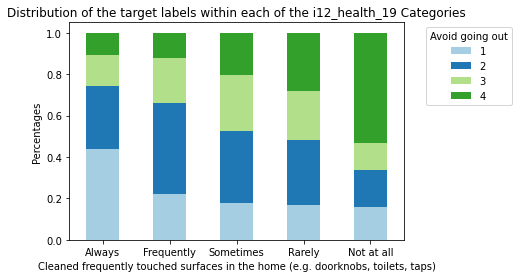

In [45]:
fig = plt.figure()
i12_19_crosstab = pd.crosstab(db['i12_health_19'], db['Target_Variable'], margins = False)
i12_19_crosstab_norm = i12_19_crosstab.div(i12_19_crosstab.sum(axis = 1), axis = 0)
ax = i12_19_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the i12_health_19 Categories', 
      xlabel = 'Cleaned frequently touched surfaces in the home (e.g. doorknobs, toilets, taps)',
      ylabel = 'Percentages',
      xticklabels=['Always','Frequently','Sometimes','Rarely','Not at all'])
plt.xticks(rotation = None)
plt.legend(title='Avoid going out', bbox_to_anchor=(1.05, 1), loc='upper left')

<Figure size 432x288 with 0 Axes>

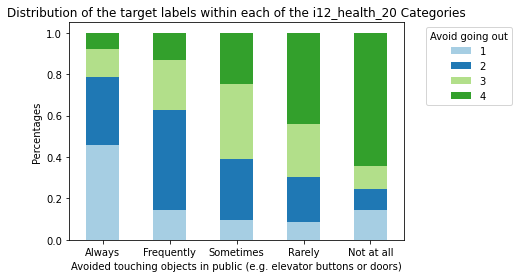

In [46]:
fig = plt.figure()
i12_20_crosstab = pd.crosstab(db['i12_health_20'], db['Target_Variable'], margins = False)
i12_20_crosstab_norm = i12_20_crosstab.div(i12_20_crosstab.sum(axis = 1), axis = 0)
ax = i12_20_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the i12_health_20 Categories', 
      xlabel = 'Avoided touching objects in public (e.g. elevator buttons or doors)',
      ylabel = 'Percentages',
      xticklabels=['Always','Frequently','Sometimes','Rarely','Not at all'])
plt.xticks(rotation = None)
plt.legend(title='Avoid going out', bbox_to_anchor=(1.05, 1), loc='upper left')

### Week

In [47]:
Week_crosstab = pd.crosstab(db['Week'], db['Target_Variable'], margins = False)

stat, p, dof, expected = chi2_contingency(Week_crosstab)
print("Test statistics: ",stat,"\np-value: ",p)

Test statistics:  920.1476858776458 
p-value:  1.2215451735157974e-163


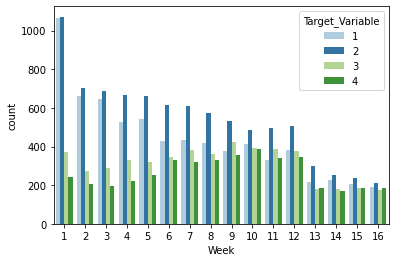

In [48]:
db=db.astype({'Week':int})
sns.countplot(x="Week", hue="Target_Variable", data=db)

<Figure size 432x288 with 0 Axes>

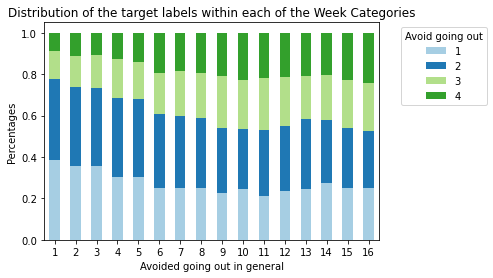

In [49]:
fig = plt.figure()
Week_crosstab = pd.crosstab(db['Week'], db['Target_Variable'], margins = False)
Week_crosstab_norm = Week_crosstab.div(Week_crosstab.sum(axis = 1), axis = 0)
ax = Week_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the Week Categories', 
      xlabel = 'Avoided going out in general',
      ylabel = 'Percentages',
      xticklabels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16'])
plt.xticks(rotation = None)
plt.legend(title='Avoid going out', bbox_to_anchor=(1.05, 1), loc='upper left')

### Demographics Related EDA

<Figure size 432x288 with 0 Axes>

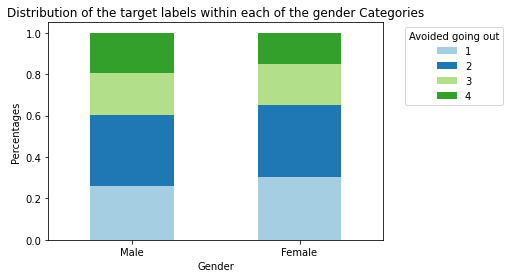

In [50]:
sns.set_palette('Paired')
fig = plt.figure()
gender_crosstab = pd.crosstab(db['gender'],db['Target_Variable'], margins = False)
gender_crosstab_norm = gender_crosstab.div(gender_crosstab.sum(axis = 1), axis = 0)
ax = gender_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the gender Categories', 
      xlabel = 'Gender',
      ylabel = 'Percentages',
      xticklabels=['Male','Female'])
plt.xticks(rotation = None)
plt.legend(title='Avoided going out', bbox_to_anchor=(1.05, 1), loc='upper left')

<Figure size 432x288 with 0 Axes>

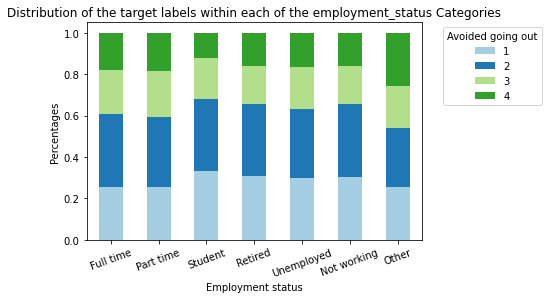

In [51]:
sns.set_palette('Paired')
fig = plt.figure()
employ_crosstab = pd.crosstab(db['employment_status'], db['Target_Variable'], margins = False)
employ_crosstab_norm = employ_crosstab.div(employ_crosstab.sum(axis = 1), axis = 0)
ax = employ_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the employment_status Categories', 
      xlabel = 'Employment status',
      ylabel = 'Percentages',
      xticklabels=['Full time', 'Part time', 'Student', 'Retired', 'Unemployed', 'Not working', 'Other'])
plt.xticks(rotation = 20)
plt.legend(title='Avoided going out', bbox_to_anchor=(1.05, 1), loc='upper left')

In [52]:
stat, p, dof, expected = chi2_contingency(employ_crosstab)
print("Test statistics: ",stat,"\np-value: ",p)

Test statistics:  176.43709765049047 
p-value:  4.862834642222309e-28


<Figure size 432x288 with 0 Axes>

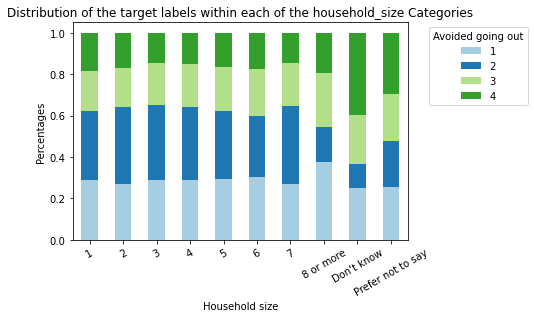

In [53]:
sns.set_palette('Paired')
fig = plt.figure()
household_size_crosstab = pd.crosstab(db['household_size'], db['Target_Variable'], margins = False)
household_size_crosstab_norm = household_size_crosstab.div(household_size_crosstab.sum(axis = 1), axis = 0)
ax = household_size_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the household_size Categories', 
      xlabel = 'Household size',
      ylabel = 'Percentages',
      xticklabels = ['1','2','3','4','5','6','7',"8 or more","Don't know", "Prefer not to say"])
plt.xticks(rotation = 30)
plt.legend(title='Avoided going out', bbox_to_anchor=(1.05, 1), loc='upper left')

In [54]:
stat, p, dof, expected = chi2_contingency(household_size_crosstab)
print("Test statistics: ",stat,"\np-value: ",p)

Test statistics:  303.103179653062 
p-value:  1.749691249676311e-48


<Figure size 432x288 with 0 Axes>

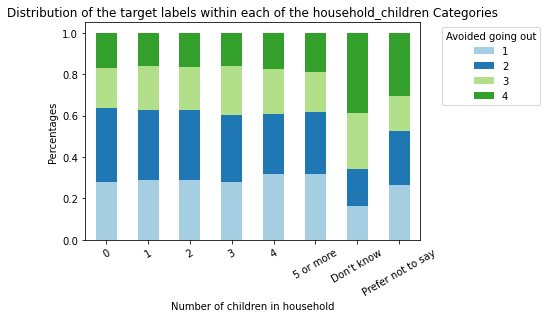

In [55]:
sns.set_palette('Paired')
fig = plt.figure()
household_children_crosstab = pd.crosstab(db['household_children'], db['Target_Variable'], margins = False)
household_children_crosstab_norm = household_children_crosstab.div(household_children_crosstab.sum(axis = 1), axis = 0)
ax = household_children_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the household_children Categories', 
      xlabel = 'Number of children in household',
      ylabel = 'Percentages',
      xticklabels = ['0','1','2','3','4','5 or more',"Don't know", "Prefer not to say"])
plt.xticks(rotation = 30)
plt.legend(title='Avoided going out', bbox_to_anchor=(1.05, 1), loc='upper left')

In [56]:
stat, p, dof, expected = chi2_contingency(household_children_crosstab)
print("Test statistics: ",stat,"\np-value: ",p)

Test statistics:  110.76743213393644 
p-value:  3.42620858167023e-14


<Figure size 432x288 with 0 Axes>

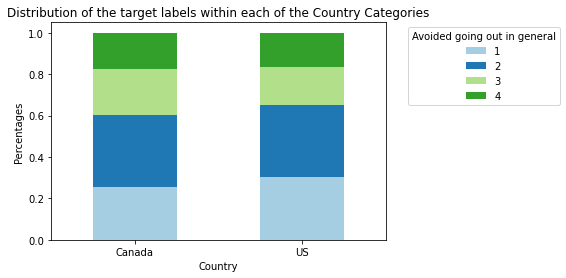

In [57]:
sns.set_palette('Paired')
fig = plt.figure()
Country_crosstab = pd.crosstab(db['Country'],db['Target_Variable'], margins = False)
Country_crosstab_norm = Country_crosstab.div(Country_crosstab.sum(axis = 1), axis = 0)
ax = Country_crosstab_norm.plot(kind = 'bar', stacked = True)
ax.set(title = 'Distribution of the target labels within each of the Country Categories', 
      xlabel = 'Country',
      ylabel = 'Percentages',
      xticklabels=['Canada', 'US'])
plt.xticks(rotation = None)
plt.legend(title='Avoided going out in general', bbox_to_anchor=(1.05, 1), loc='upper left')

In [58]:
pd.crosstab(db['Country'], db['Target_Variable'], margins = True)

Target_Variable,1,2,3,4,All
Country,,,,,
1,2601,3587,2279,1821,10288
2,4458,5018,2694,2437,14607
All,7059,8605,4973,4258,24895


In [59]:
Country_crosstab = pd.crosstab(db['Country'], db['Target_Variable'], margins = False)
stat, p, dof, expected = chi2_contingency(Country_crosstab)
print("Test statistics: ",stat,"\np-value: ",p)

Test statistics:  104.07445541842833 
p-value:  2.0665488017070982e-22


## Model Development 

### Model 1

In [56]:
y=db.loc[:,"Target_Variable"]
X=db.drop(['Target_Variable', 'Index'], axis = 1)

In [57]:
# split off test data using 80/20 split
seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

#cross validation with k_fold = 5
num_folds = 5
scoring = 'accuracy'

# standardize feature data
sc = StandardScaler()
scaler = sc.fit(X_train)
rescaledX = scaler.transform(X_train)
rescaledX_test = scaler.transform(X_test)

In [58]:
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

msg = "KNN: \n mean cv score:%f (std: %f)" % (cv_results.mean(), cv_results.std())
msg

'KNN: \n mean cv score:0.433822 (std: 0.003457)'

#### Parameter Tuninig

In [59]:
k_values = np.array([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43])
param_grid = dict(n_neighbors=k_values)

kfold = KFold(n_splits = num_folds, shuffle = True, random_state=seed)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold,
                    n_jobs=-1, verbose = 2, return_train_score = True)
grid_result = grid.fit(rescaledX, y_train)

print("\n Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed: 17.1min finished



 Best: 0.491866 using {'n_neighbors': 43}


In [60]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" %(mean, stdev, param))

0.437438 (0.007274) with: {'n_neighbors': 1}
0.446977 (0.003628) with: {'n_neighbors': 3}
0.467413 (0.005868) with: {'n_neighbors': 5}
0.471480 (0.007187) with: {'n_neighbors': 7}
0.475647 (0.010443) with: {'n_neighbors': 9}
0.479564 (0.007039) with: {'n_neighbors': 11}
0.484686 (0.006432) with: {'n_neighbors': 13}
0.483229 (0.009273) with: {'n_neighbors': 15}
0.485087 (0.007109) with: {'n_neighbors': 17}
0.485941 (0.007926) with: {'n_neighbors': 19}
0.484786 (0.006791) with: {'n_neighbors': 21}
0.487146 (0.006505) with: {'n_neighbors': 23}
0.487849 (0.003838) with: {'n_neighbors': 25}
0.485188 (0.004328) with: {'n_neighbors': 27}
0.486393 (0.004168) with: {'n_neighbors': 29}
0.486192 (0.006279) with: {'n_neighbors': 31}
0.487899 (0.005731) with: {'n_neighbors': 33}
0.488702 (0.007285) with: {'n_neighbors': 35}
0.487949 (0.005840) with: {'n_neighbors': 37}
0.491364 (0.003760) with: {'n_neighbors': 39}
0.491615 (0.004101) with: {'n_neighbors': 41}
0.491866 (0.005971) with: {'n_neighbors

Text(0, 0.5, 'Accuracy')

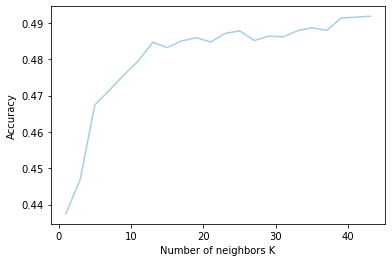

In [61]:
plt.plot(k_values, means)
plt.xlabel("Number of neighbors K")
plt.ylabel("Accuracy")

#### Model Performance 

In [62]:
k = grid.best_params_['n_neighbors']
model = KNeighborsClassifier(n_neighbors = k)
model.fit(rescaledX, y_train)

y_pred = model.predict(rescaledX_test)

In [63]:
accuracy_score(y_pred, y_test)

0.487447278569994

In [64]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.55      0.54      0.54      1458
           2       0.65      0.43      0.51      2643
           3       0.19      0.41      0.26       454
           4       0.40      0.77      0.52       424

    accuracy                           0.49      4979
   macro avg       0.45      0.54      0.46      4979
weighted avg       0.56      0.49      0.50      4979



### Model 2

In [56]:
features = ['i12_health_1','i12_health_2','i12_health_3','i12_health_4','i12_health_5','i12_health_7', 'i12_health_8', 
            'i12_health_9', 'i12_health_10', 'i12_health_11', 'i12_health_12', 'i12_health_13','i12_health_14', 
            'i12_health_15', 'i12_health_16', 'i12_health_17', 'i12_health_18', 'i12_health_19', 'i12_health_20',
            'Disease_Yes', 'Week' ,'Occ_Yes', 'i14_health_99_Yes']
y=db.loc[:,"Target_Variable"]
X=db.loc[:,features]

In [57]:
# split off test data using 80/20 split
seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

#cross validation with k_fold = 5
num_folds = 5
scoring = 'accuracy'

# standardize feature data
sc = StandardScaler()
scaler = sc.fit(X_train)
rescaledX = scaler.transform(X_train)
rescaledX_test = scaler.transform(X_test)

In [58]:
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

msg = "KNN: \n mean cv score:%f (std: %f)" % (cv_results.mean(), cv_results.std())
msg

'KNN: \n mean cv score:0.511448 (std: 0.003668)'

#### Parameter Tuning

In [59]:
k_values = np.array([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43])
param_grid = dict(n_neighbors=k_values)

kfold = KFold(n_splits = num_folds, shuffle = True, random_state=seed)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold,
                    n_jobs=-1, verbose = 2, return_train_score = True)
grid_result = grid.fit(rescaledX, y_train)

print("\n Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:  5.5min finished



 Best: 0.536504 using {'n_neighbors': 15}


In [60]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" %(mean, stdev, param))

0.470525 (0.010852) with: {'n_neighbors': 1}
0.497238 (0.003875) with: {'n_neighbors': 3}
0.515314 (0.003024) with: {'n_neighbors': 5}
0.523348 (0.004519) with: {'n_neighbors': 7}
0.529022 (0.004860) with: {'n_neighbors': 9}
0.531131 (0.003144) with: {'n_neighbors': 11}
0.532738 (0.006013) with: {'n_neighbors': 13}
0.536504 (0.005135) with: {'n_neighbors': 15}
0.534947 (0.006528) with: {'n_neighbors': 17}
0.533190 (0.006680) with: {'n_neighbors': 19}
0.533592 (0.005538) with: {'n_neighbors': 21}
0.533893 (0.004162) with: {'n_neighbors': 23}
0.534596 (0.006769) with: {'n_neighbors': 25}
0.533591 (0.006313) with: {'n_neighbors': 27}
0.534345 (0.005883) with: {'n_neighbors': 29}
0.533340 (0.007859) with: {'n_neighbors': 31}
0.533742 (0.007597) with: {'n_neighbors': 33}
0.535951 (0.008915) with: {'n_neighbors': 35}
0.534445 (0.009752) with: {'n_neighbors': 37}
0.533591 (0.009870) with: {'n_neighbors': 39}
0.533541 (0.008837) with: {'n_neighbors': 41}
0.534294 (0.007934) with: {'n_neighbors

Text(0, 0.5, 'Accuracy')

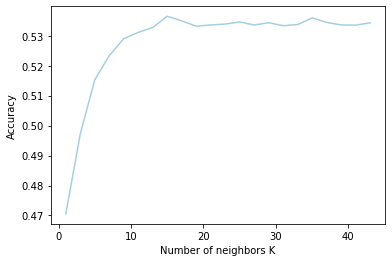

In [61]:
plt.plot(k_values, means)
plt.xlabel("Number of neighbors K")
plt.ylabel("Accuracy")

#### Model Performance

In [62]:
k = grid.best_params_['n_neighbors']
model = KNeighborsClassifier(n_neighbors = k)
model.fit(rescaledX, y_train)

y_pred = model.predict(rescaledX_test)

In [63]:
accuracy_score(y_pred, y_test)

0.5364531030327375

In [64]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.62      0.59      0.61      1522
           2       0.61      0.49      0.54      2189
           3       0.33      0.43      0.37       746
           4       0.47      0.75      0.58       522

    accuracy                           0.54      4979
   macro avg       0.51      0.56      0.52      4979
weighted avg       0.56      0.54      0.54      4979



### Model 3 - model of our choice

In [73]:
# Model of choice
features = ['i12_health_5','i12_health_7', 'i12_health_8', 'i12_health_11', 'i12_health_12', 'i12_health_13',
        'i12_health_14', 'i12_health_15', 'i12_health_16', 'i12_health_17', 'i12_health_18', 'i12_health_19', 'i12_health_20',
        'Disease_Yes']
y=db.loc[:,"Target_Variable"]
X=db.loc[:,features]

# split off test data using 80/20 split
seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# standardize feature data
sc = StandardScaler()
scaler = sc.fit(X_train)
rescaledX = scaler.transform(X_train)
rescaledX_test = scaler.transform(X_test)

#cross validation with k_fold = 5
num_folds = 5
scoring = 'accuracy'

In [74]:
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

msg = "KNN: \n mean cv score:%f (std: %f)" % (cv_results.mean(), cv_results.std())
msg

'KNN: \n mean cv score:0.535449 (std: 0.003249)'

#### Parameter Tuning

In [75]:
kfold = KFold(n_splits = num_folds, shuffle = True, random_state=seed)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold,
                    n_jobs=-1, verbose = 2, return_train_score = True)
grid_result = grid.fit(rescaledX, y_train)

print("\n Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:  2.1min finished



 Best: 0.563768 using {'n_neighbors': 39}


In [76]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" %(mean, stdev, param))

0.483380 (0.009091) with: {'n_neighbors': 1}
0.513406 (0.004085) with: {'n_neighbors': 3}
0.539666 (0.004839) with: {'n_neighbors': 5}
0.550663 (0.005322) with: {'n_neighbors': 7}
0.554278 (0.003990) with: {'n_neighbors': 9}
0.555533 (0.005327) with: {'n_neighbors': 11}
0.555082 (0.008874) with: {'n_neighbors': 13}
0.560504 (0.007158) with: {'n_neighbors': 15}
0.561960 (0.008203) with: {'n_neighbors': 17}
0.560454 (0.006014) with: {'n_neighbors': 19}
0.563416 (0.006553) with: {'n_neighbors': 21}
0.563065 (0.007822) with: {'n_neighbors': 23}
0.561558 (0.008786) with: {'n_neighbors': 25}
0.561860 (0.007414) with: {'n_neighbors': 27}
0.562161 (0.006828) with: {'n_neighbors': 29}
0.561458 (0.007893) with: {'n_neighbors': 31}
0.561609 (0.008697) with: {'n_neighbors': 33}
0.562964 (0.008731) with: {'n_neighbors': 35}
0.563065 (0.007621) with: {'n_neighbors': 37}
0.563768 (0.007447) with: {'n_neighbors': 39}
0.562663 (0.006786) with: {'n_neighbors': 41}
0.562864 (0.007362) with: {'n_neighbors

Text(0, 0.5, 'Accuracy')

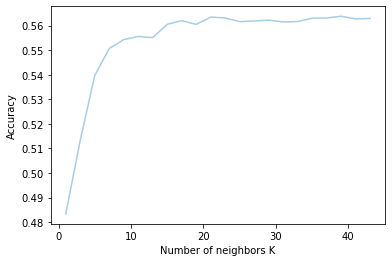

In [77]:
plt.plot(k_values, means)
plt.xlabel("Number of neighbors K")
plt.ylabel("Accuracy")

#### Model Performance

In [78]:
k = grid.best_params_['n_neighbors']
model = KNeighborsClassifier(n_neighbors = k)
model.fit(rescaledX, y_train)

y_pred = model.predict(rescaledX_test)

In [79]:
print(accuracy_score(y_pred, y_test))

0.5657762602932316


In [80]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.62      0.67      0.64      1353
           2       0.68      0.51      0.58      2290
           3       0.35      0.44      0.39       771
           4       0.49      0.72      0.58       565

    accuracy                           0.57      4979
   macro avg       0.53      0.58      0.55      4979
weighted avg       0.59      0.57      0.57      4979



In [110]:
confusion_matrix(y_pred, y_test)

array([[ 900,  352,   79,   22],
       [ 455, 1171,  476,  188],
       [  59,  164,  341,  207],
       [  27,   47,   86,  405]], dtype=int64)